https://dumps.wikimedia.org/
https://dumps.wikimedia.org/enwiki/
    
https://github.com/attardi/wikiextractor

In [1]:
import json
import gzip
from tqdm import tqdm_notebook as tqdm

wiki15k_filename = 'wiki15k'

In [2]:
from sacremoses import MosesTokenizer

tokenizer = MosesTokenizer("en")

In [3]:
with gzip.open(wiki15k_filename, 'r') as input:
    articles = [json.loads(jsoned_article) for jsoned_article in tqdm(input)]

In [4]:
print(json.dumps(articles[0], indent=4))

{
    "_id": "en_34590860",
    "title": "Kimvula Territory",
    "cats_imported": [
        "other"
    ],
    "content": "Kimvula is a territory in the Kongo Central province of the Democratic Republic of the Congo. Its seat is the town of Kimvula."
}


In [5]:
articles_tokenized = []
for article in tqdm(articles):
    article['tokenized_content'] = tokenizer.tokenize(article['content'])

In [6]:
print(articles[0]['content'])
print(articles[0]['tokenized_content'])

Kimvula is a territory in the Kongo Central province of the Democratic Republic of the Congo. Its seat is the town of Kimvula.
['Kimvula', 'is', 'a', 'territory', 'in', 'the', 'Kongo', 'Central', 'province', 'of', 'the', 'Democratic', 'Republic', 'of', 'the', 'Congo', '.', 'Its', 'seat', 'is', 'the', 'town', 'of', 'Kimvula', '.']


In [7]:
import nltk
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/quora/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/quora/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
from lingvo import mapping as pos_mapping

In [9]:
to_nltk = {
    'VERB': nltk.corpus.reader.wordnet.VERB,
    'ADJ': nltk.corpus.reader.wordnet.ADJ,
    'NOUN': nltk.corpus.reader.wordnet.NOUN,
    'ADV': nltk.corpus.reader.wordnet.ADV,
    'ADJ_SAT': nltk.corpus.reader.wordnet.ADJ_SAT,
}

def get_pos_many(words, filter=[]):
    preres = [_[1] for _ in nltk.pos_tag(words)]
    res = [pos_mapping.get(_) for _ in preres]
    res = [None if res in filter else _ for _ in res]
    res = [to_nltk.get(_, 'n') for _ in res]

    return res


def lemmatize_phrase(words, filter=['PUNCT', 'SYM', 'PRON', 'ADP', 'DET'], preserve_case=False):
    words = [word.lower() for word in words]
    pos_tags = get_pos_many(words, filter)

    res = tuple(wordnet_lemmatizer.lemmatize(w, p) for w, p in zip(words, pos_tags) if (p is not None) or p  )
    return res

In [10]:
for article in tqdm(articles):
    article['lemmatized_content'] = lemmatize_phrase(article['tokenized_content'])

In [11]:
list(zip(articles[0]['tokenized_content'], articles[0]['lemmatized_content']))

[('Kimvula', 'kimvula'),
 ('is', 'be'),
 ('a', 'a'),
 ('territory', 'territory'),
 ('in', 'in'),
 ('the', 'the'),
 ('Kongo', 'kongo'),
 ('Central', 'central'),
 ('province', 'province'),
 ('of', 'of'),
 ('the', 'the'),
 ('Democratic', 'democratic'),
 ('Republic', 'republic'),
 ('of', 'of'),
 ('the', 'the'),
 ('Congo', 'congo'),
 ('.', '.'),
 ('Its', 'its'),
 ('seat', 'seat'),
 ('is', 'be'),
 ('the', 'the'),
 ('town', 'town'),
 ('of', 'of'),
 ('Kimvula', 'kimvula'),
 ('.', '.')]

In [12]:
from pymorphy2 import MorphAnalyzer

In [13]:
russian_example_line = 'Русская фраза, на русском языке, не самая сложная, но и не очень простая.'

In [14]:
russian_tokenizer = MosesTokenizer("ru")

In [15]:
rus_tokens = russian_tokenizer.tokenize(russian_example_line)

In [16]:
morph = MorphAnalyzer()

In [17]:
rus_lemmas = [morph.parse(token)[0].normal_form for token in rus_tokens]

In [18]:
print(russian_example_line)
print(rus_tokens)
print(rus_lemmas)

Русская фраза, на русском языке, не самая сложная, но и не очень простая.
['Русская', 'фраза', ',', 'на', 'русском', 'языке', ',', 'не', 'самая', 'сложная', ',', 'но', 'и', 'не', 'очень', 'простая', '.']
['русский', 'фраза', ',', 'на', 'русский', 'язык', ',', 'не', 'самый', 'сложный', ',', 'но', 'и', 'не', 'очень', 'простой', '.']


In [19]:
nltk.download('stopwords')
from nltk.corpus import stopwords

from collections import Counter

from string import punctuation

[nltk_data] Downloading package stopwords to /home/quora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
tokens_counter = Counter()
for article in tqdm(articles):
    tokens_counter.update(article['lemmatized_content'])

In [21]:
acceptable_tokens = []
for w, c in tokens_counter.items():
    if 5 < c < 5000:
        acceptable_tokens.append(w)
acceptable_tokens = set(_.lower() for _ in acceptable_tokens)
acceptable_tokens = acceptable_tokens - set(punctuation)
acceptable_tokens = acceptable_tokens - set(stopwords.words('english'))

In [22]:
len(acceptable_tokens)

11532

In [23]:
for article in tqdm(articles):
    filtered_tokens = []
    for token in article['lemmatized_content']:
        if token in acceptable_tokens:
            filtered_tokens.append(token)
    article['lemmatized_filtered_content'] = filtered_tokens

In [24]:
articles[0]['lemmatized_filtered_content']

['territory',
 'central',
 'province',
 'democratic',
 'republic',
 'congo',
 'seat',
 'town']

In [25]:
from gensim.models.word2vec import Word2Vec
from gensim.models.fasttext import FastText

In [26]:
corpora_prepared = [(article['lemmatized_filtered_content']) for article in articles]

In [27]:
w2v_model = Word2Vec(sentences=corpora_prepared)

In [28]:
w2v_model.wv.similar_by_word('june')

/home/quora/miniconda3/envs/py36/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('april', 0.9956282377243042),
 ('august', 0.9950224757194519),
 ('december', 0.9941427707672119),
 ('july', 0.9933923482894897),
 ('march', 0.9929090142250061),
 ('october', 0.9926407337188721),
 ('november', 0.990996778011322),
 ('september', 0.989435076713562),
 ('february', 0.9873470664024353),
 ('january', 0.983225405216217)]

In [29]:
fasttext_model = FastText(size=100, window=5, workers=20)

fasttext_model.build_vocab(corpora_prepared)

In [30]:
fasttext_model.train(sentences=corpora_prepared, total_examples=len(corpora_prepared), epochs=4)

In [31]:
fasttext_model.wv.similar_by_word('june')

[('july', 0.9900041222572327),
 ('april', 0.9885839223861694),
 ('jun', 0.9855756759643555),
 ('juno', 0.9840654134750366),
 ('augusta', 0.981198251247406),
 ('august', 0.9790916442871094),
 ('augusto', 0.9751795530319214),
 ('february', 0.9690930247306824),
 ('jg', 0.9678722023963928),
 ('–', 0.9668600559234619)]

In [32]:
# !wget -x16 https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

# !unzip wiki-news-300d-1M.vec.zip

wget: invalid option -- '1'
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
Archive:  wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [35]:
from gensim.models.keyedvectors import KeyedVectors

In [34]:
w2v_model_pretrained = KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')

KeyboardInterrupt: 

In [36]:
w2v_model_pretrained.similar_by_word('june')

NameError: name 'w2v_model_pretrained' is not defined

In [37]:
w2v_model_pretrained.similar_by_word('conference')

NameError: name 'w2v_model_pretrained' is not defined

In [38]:
import numpy as np

for article in tqdm(articles):
    word_vectors = []
    for word in article['lemmatized_filtered_content']:
        word_vectors.append(w2v_model.wv.get_vector(word))
    if len(word_vectors) == 0:
        article['vector'] = np.zeros(100)
    elif len(word_vectors) == 1:
        article['vector'] = word_vectors[0]
    else:
        article['vector'] = np.mean(word_vectors, axis=0)
#     if np.isnan(article['vector']).sum() > 0:
#         article['vector'] = np.zeros(100)
        

In [39]:
articles_vectors = np.zeros((len(articles), 100))
for i, article in enumerate(articles):
    articles_vectors[i] = article['vector']

In [40]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt
%matplotlib inline

In [41]:
projector = PCA(2)

In [42]:
vecs_to_draw = projector.fit_transform(articles_vectors)

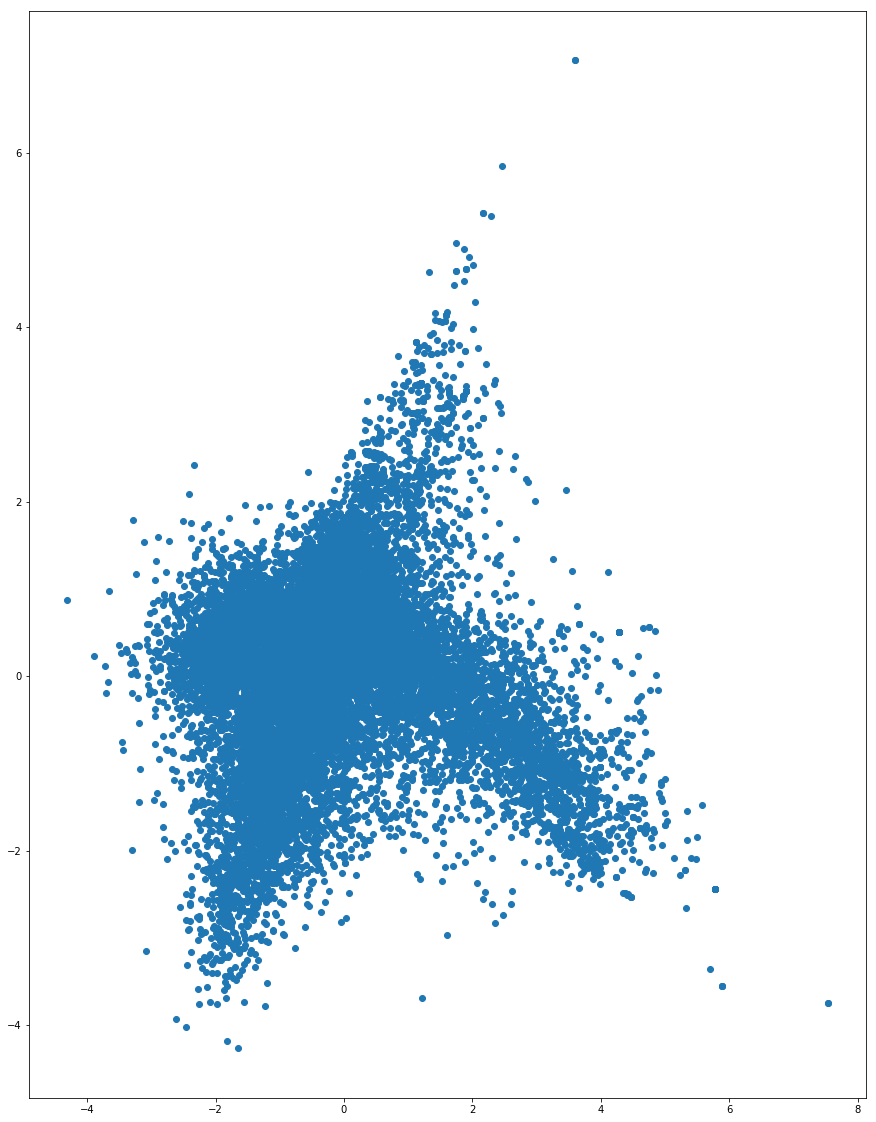

In [43]:
plt.figure(figsize=(15, 20))
plt.scatter(vecs_to_draw[:, 0], vecs_to_draw[:, 1])

In [44]:
projector = TSNE(2,)

In [45]:
vecs_to_draw = projector.fit_transform(articles_vectors)

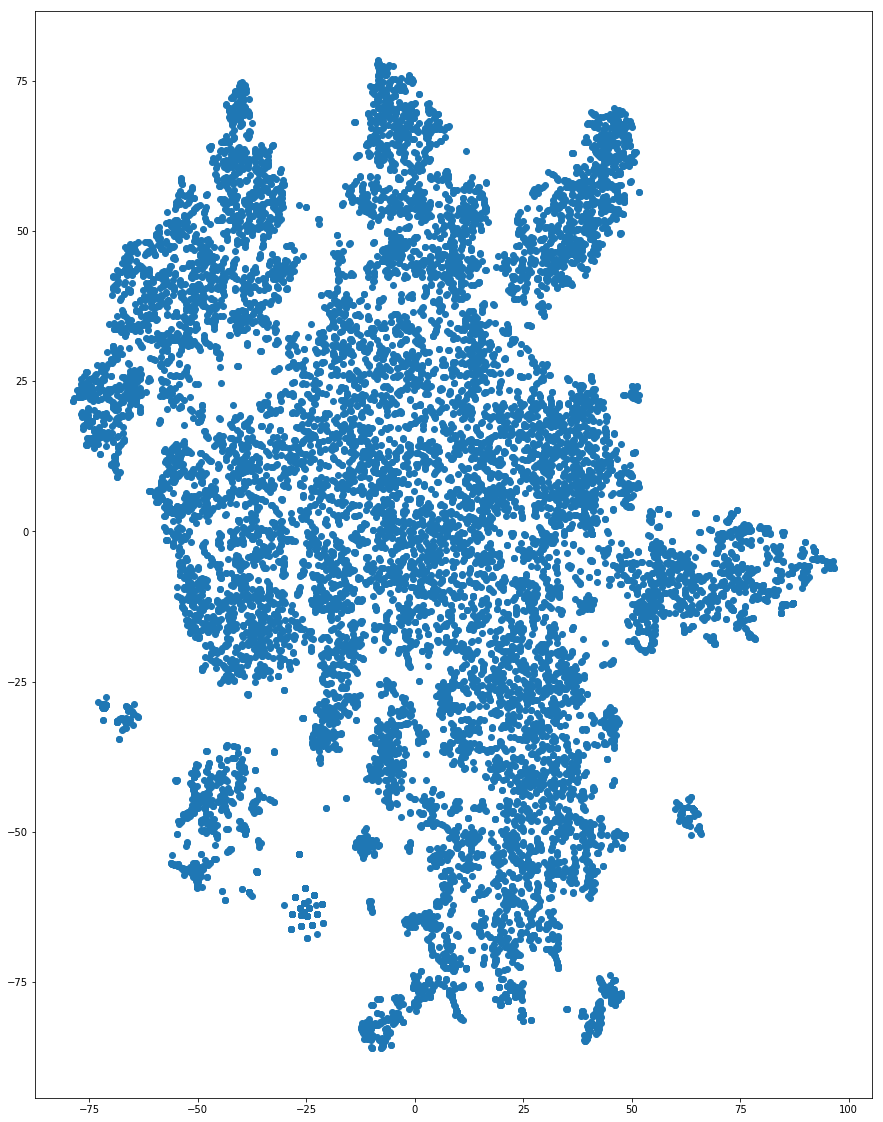

In [46]:
plt.figure(figsize=(15, 20))
plt.scatter(vecs_to_draw[:, 0], vecs_to_draw[:, 1])

In [47]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier

In [48]:
interesting_articles = [article for article in articles if article['cats_imported'][0] != 'other']

In [49]:
Xs = [article['vector'] for article in interesting_articles]

In [50]:
ys = np.array([article['cats_imported'][0] for article in interesting_articles]).reshape(-1, 1)

In [51]:
y_encoder = OneHotEncoder()

y_encoder.fit(ys)

ys = y_encoder.transform(ys).todense()

In [52]:
cls = KNeighborsClassifier()

In [53]:
cls.fit(Xs, ys)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [54]:
y_encoder.inverse_transform(cls.predict([Xs[123]]))

array([['engineering']], dtype='<U19')

In [55]:
interesting_articles[123]['title'], interesting_articles[123]['content']

('Messerschmitt Me 263',
 'The Messerschmitt Me 263 Scholle (plaice) was a rocket-powered fighter aircraft developed from the Me 163 Komet towards the end of World War II. Three prototypes were built but never flown under their own power as the rapidly deteriorating military situation in Germany prevented the completion of the test program.')